In [43]:
import numpy as np
import pandas as pd
from copy import copy
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from factor_analyzer import FactorAnalyzer, calculate_bartlett_sphericity, calculate_kmo
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import seaborn as sns

import os
for dirname, _, filenames in os.walk('kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import warnings

def remove_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df.reset_index(drop=True)

def smooth_columns(df, columns, window=3):
    df_copy = df.copy()
    for col in columns:
        df_copy[col] = df_copy[col].rolling(window=window, center=True, min_periods=1).mean()
    return df_copy

warnings.filterwarnings('ignore')

data = pd.read_csv("s_dataset.csv")

numeric_cols = ['ID', 'Age', 'Income', 'WorkExperience', 'Satisfaction', 'SpendingHabits', 'Score1', 'Score2','Score3', 'Score4']
data[numeric_cols] = data[numeric_cols].apply(pd.to_numeric, errors='coerce')

data = data.dropna()

data = data.reset_index(drop=True)

data_second_press = remove_outliers_iqr(data, numeric_cols)

data_smoothed = smooth_columns(data_second_press, numeric_cols)

data_clean = data_smoothed.drop_duplicates().reset_index(drop=True)




education_order = {
    "High School": 1,
    "Bachelor": 2,
    "Master": 3,
    "PhD": 4
}

data_clean["EducationLevel"] = data_clean["EducationLevel"].map(education_order)

frequency_order = {
    "Rarely": 1,
    "Yearly": 2,
    "Monthly": 3,
    "Weekly": 4
}

data_clean["PurchaseFrequency"] = data_clean["PurchaseFrequency"].map(frequency_order)

object_columns = data_clean.select_dtypes(include=['object']).columns
labels = {}

for col in object_columns:
    le = LabelEncoder()
    data_clean[col] = le.fit_transform(data_clean[col])
    labels[col] = le

data_clean

,ID,Age,Income,EducationLevel,WorkExperience,Satisfaction,SpendingHabits,Region,PurchaseFrequency,ProductCategory,Score1,Score2,Score3,Score4,Score5,Group
0,40.500000,34.500000,63696.783767,4,33.000000,43.500000,51780.432669,0,1,1,40435.786528,29824.455261,57790.037549,35004.537606,64282.283890,2
1,42.666667,40.666667,61918.468680,2,35.333333,40.666667,51636.207673,3,3,3,49754.272971,31716.369569,61655.920738,34461.839790,34950.970114,0
2,39.333333,41.000000,47087.458845,3,33.666667,48.000000,64472.700426,2,1,2,52568.874056,48609.843301,63267.551070,41832.105908,61641.309975,0
3,52.000000,39.333333,49575.012234,2,41.000000,47.000000,58809.623487,3,2,1,44110.047339,46647.467577,64337.759469,40616.205799,61656.770319,2
4,42.666667,32.666667,51693.079562,1,43.333333,51.666667,52585.090088,2,1,2,38860.131536,46189.666261,59879.389227,39903.084324,79153.247117,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9772,46.000000,43.666667,53420.267520,4,39.000000,57.666667,45475.674771,1,1,0,73866.705105,31566.634403,39908.792975,53708.138757,42897.337473,0
9773,45.000000,51.000000,47662.062536,3,35.000000,60.666667,48058.071203,2,2,0,65536.704516,44132.613638,48781.879601,53684.576930,48811.788024,0
9774,41.666667,39.000000,31046.873528,2,42.333333,56.666667,51600.579874,1,4,2,65873.412420,34405.341546,51626.547746,51606.077123,28850.595200,0
9775,43.333333,35.000000,21511.605092,4,35.000000,56.333333,56001.566286,2,1,0,33178.111314,50826.222566,62678.560040,51388.959483,80775.769246,0


In [44]:
data = data_clean

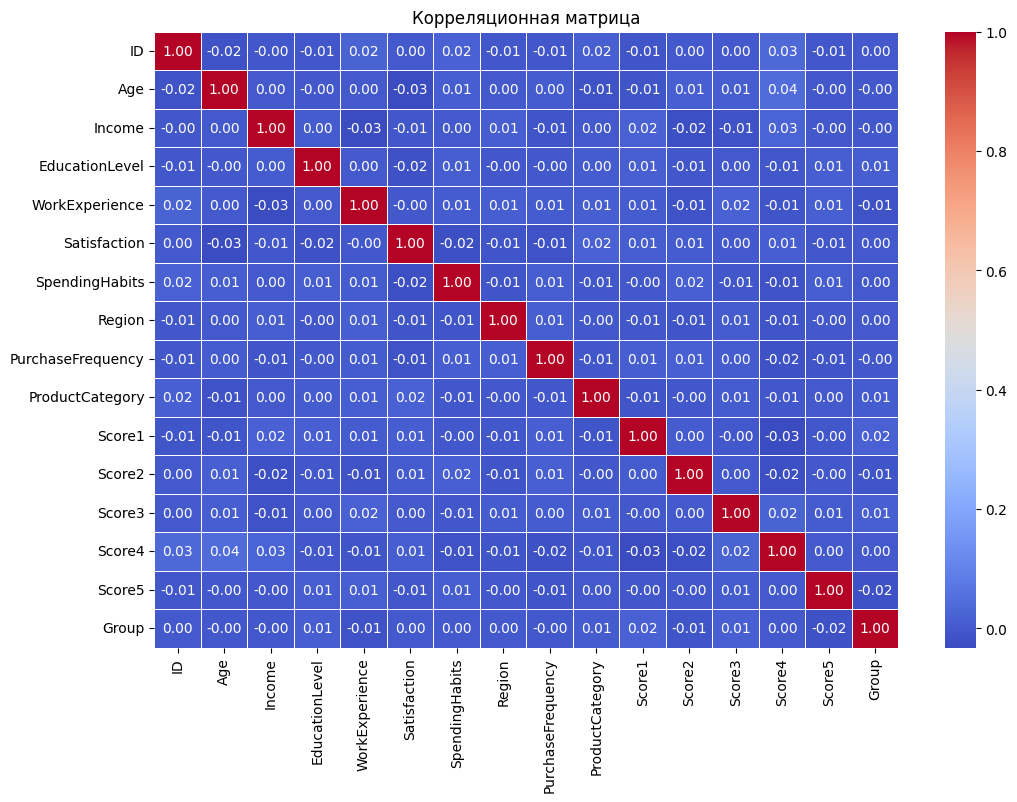

                     Age  EducationLevel
Age             1.000000       -0.004679
EducationLevel -0.004679        1.000000


In [45]:
corr_matrix = data.corr(method='spearman')
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Корреляционная матрица")
plt.show()

print(data[["Age", "EducationLevel"]].corr())

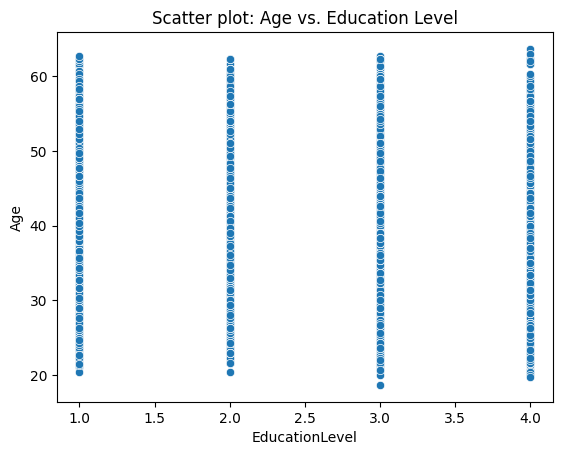

In [46]:
sns.scatterplot(x='EducationLevel', y='Age', data=data)
plt.title("Scatter plot: Age vs. Education Level")
plt.show()

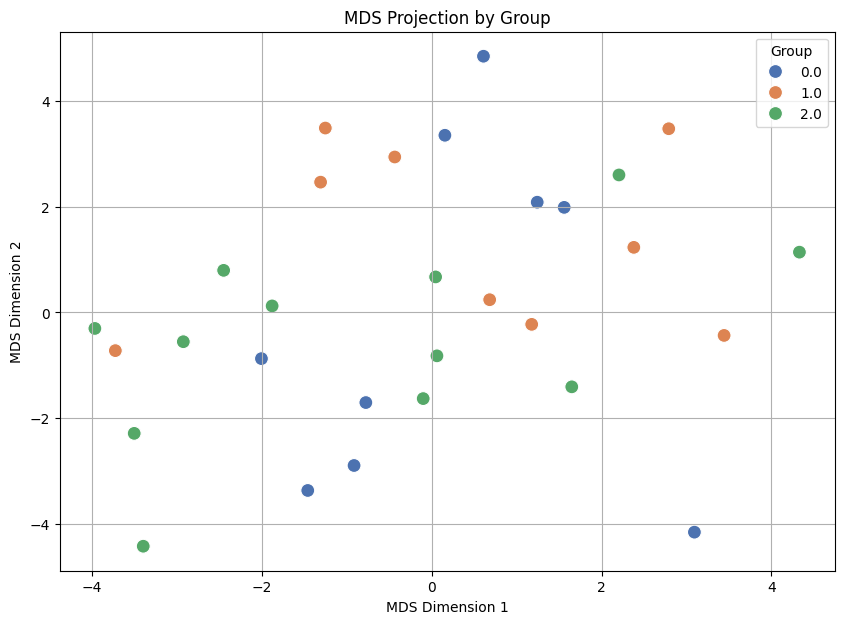

In [47]:
data_sampled = data.sample(n=500, random_state=42)

scaler = StandardScaler()
features_scaled = scaler.fit_transform(data_sampled)

mds = MDS(n_components=2, random_state=42)
mds_coords = mds.fit_transform(features_scaled)

mds_df = pd.DataFrame(mds_coords, columns=["MDS1", "MDS2"])
mds_df["Group"] = data_sampled["Group"]

plt.figure(figsize=(10, 7))
sns.scatterplot(data=mds_df, x="MDS1", y="MDS2", hue="Group", palette="deep", s=100)
plt.title("MDS Projection by Group")
plt.xlabel("MDS Dimension 1")
plt.ylabel("MDS Dimension 2")
plt.grid(True)
plt.legend(title="Group")
plt.show()

 Bartlett's Test:
Chi-square: 132.94241112879993, p-value: 2.045122286017472e-06
KMO: 0.5028112033996224


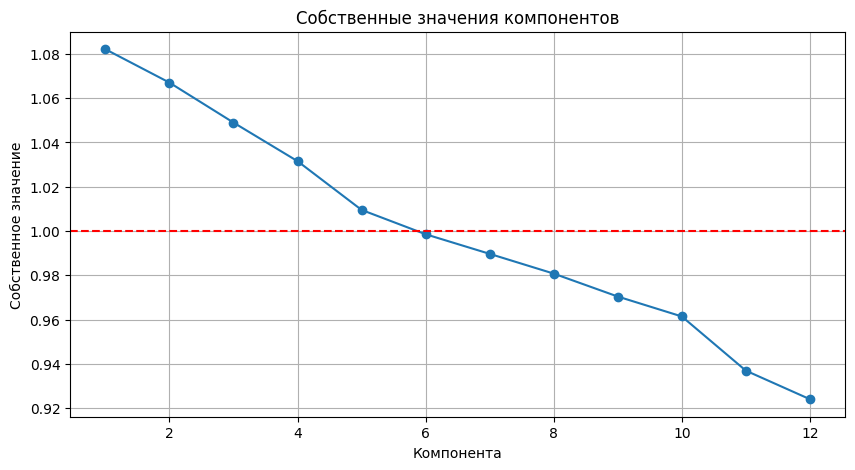

In [48]:
# 1. Выбор числовых переменных для анализа
cols_to_analyze = ['Age', 'Income', 'EducationLevel', 'WorkExperience', 
                   'Satisfaction', 'SpendingHabits', 'PurchaseFrequency',
                   'Score1', 'Score2', 'Score3', 'Score4', 'Score5']

# Стандартизация данных
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[cols_to_analyze])

# 2. Проверка пригодности для факторного анализа
# 2.1 Тест Бартлетта
chi_square_value, p_value = calculate_bartlett_sphericity(data_scaled)
print(f" Bartlett's Test:\nChi-square: {chi_square_value}, p-value: {p_value}")

# 2.2 KMO
kmo_all, kmo_model = calculate_kmo(data_scaled)
print(f"KMO: {kmo_model}")

# 3. Определение количества факторов (по собственным значениям)
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(data_scaled)
ev = pca.explained_variance_

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(ev)+1), ev, marker='o')
plt.title('Собственные значения компонентов')
plt.xlabel('Компонента')
plt.ylabel('Собственное значение')
plt.grid()
plt.axhline(y=1, color='r', linestyle='--')
plt.show()

Факторные нагрузки:
                   Factor1  Factor2  Factor3  Factor4  Factor5  Factor6
Age                  -0.00    -0.01     0.18     0.05     0.06     0.03
Income                0.02    -0.00     0.05    -0.07     0.01    -0.14
EducationLevel        0.01     0.01    -0.02    -0.02     0.06    -0.02
WorkExperience        0.01     0.00    -0.01    -0.05     0.03     0.27
Satisfaction          0.01     0.00    -0.07     0.01    -0.28     0.01
SpendingHabits       -0.01     0.01     0.00     0.05     0.09     0.01
PurchaseFrequency     0.01    -0.02    -0.02     0.03     0.07     0.04
Score1                1.00    -0.00    -0.04     0.00     0.03    -0.02
Score2                0.00    -0.00     0.01     0.32     0.02     0.00
Score3               -0.00     0.01     0.06     0.00    -0.02     0.10
Score4               -0.01     0.01     0.31    -0.08    -0.10    -0.05
Score5                0.00     0.91    -0.00    -0.00     0.04     0.04


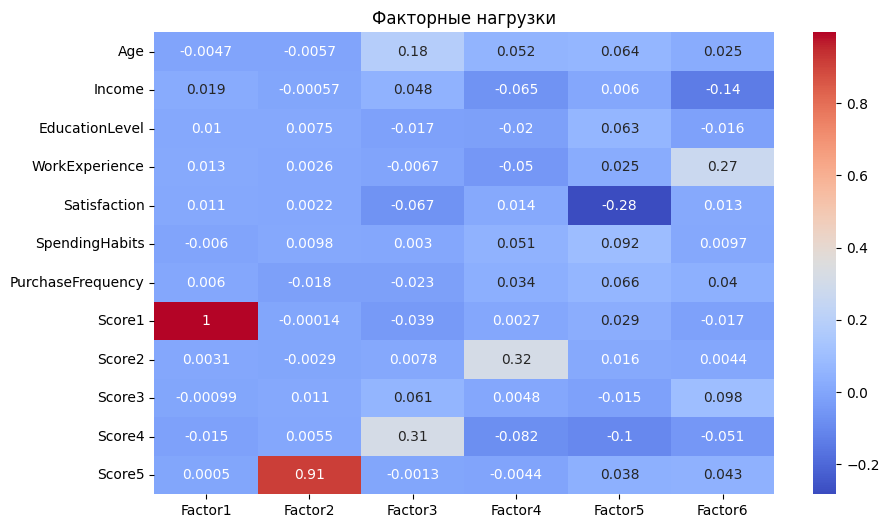

In [60]:
# Предположим, мы выбираем 4 фактора (если из графика видно, что после 4-х значения < 1)

fa_count = 6

fa = FactorAnalyzer(n_factors=fa_count, rotation='varimax')
fa.fit(data_scaled)

# Получение факторных нагрузок
loadings = pd.DataFrame(fa.loadings_, index=cols_to_analyze, columns=[f'Factor{i+1}' for i in range(fa_count)])
print("Факторные нагрузки:")
print(loadings.round(2))

# Визуализация факторных нагрузок
plt.figure(figsize=(10, 6))
sns.heatmap(loadings, annot=True, cmap='coolwarm')
plt.title('Факторные нагрузки')
plt.show()


In [ ]:
# Доля объясненной дисперсии
variance = fa.get_factor_variance()
variance_df = pd.DataFrame({
    "Суммарная дисперсия": variance[0],
    "Процент объясненной": variance[1],
    "Кумулятивная": variance[2]
}, index=[f'Factor{i+1}' for i in range(fa_count)])
print(variance_df.round(3))

         Суммарная дисперсия  Процент объясненной  Кумулятивная
Factor1                0.189                0.016         0.016
Factor2                0.097                0.008         0.024
Factor3                0.094                0.008         0.032
